# Spline Bicubic

Nesse caderno iremos trabalhar numa nova técnica de recriar campos 3d a partir de seus pontos utilizando o método de interpolação bicúbica.

Esse método consiste em utilizar a interpolação cúbica tanto no eixo $x$ quanto no eixo $y$. 

Nesse caderno, iremos trabalhar com as condições de cortorno manualmente para que possamos obter e trabahar diferetnes técnica dessa interpolação.

### Rascuho

Neste primeito momento eu faço alguns rascunho sobre o uso de funções do numpy

In [1]:
import numpy as np

from numpy import polynomial
from numpy.polynomial.polynomial import Polynomial
from numpy.polynomial.polynomial import polyval

pol = Polynomial([1,2,3])

pol(1)

6.0

Dado um polinomio $p(x) = 4 - 4x^2 + 3x^3$, podemos obter o valor do do polinomio no ponto x utilizando a função `polyval`

In [2]:
pol2 = Polynomial([4, 0, -4, 3])
print(pol2)

for x in range(-3, 3):
    print(x, pol2(x))

poly([ 4.  0. -4.  3.])
-3 -113.0
-2 -36.0
-1 -3.0
0 4.0
1 3.0
2 12.0


In [3]:
pol2.linspace(6, domain=[-3,2])

(array([-3., -2., -1.,  0.,  1.,  2.]),
 array([-113.,  -36.,   -3.,    4.,    3.,   12.]))

### Trabalhando com matriz no numpy


Para cada matriz, temos que o número de regiões no eixo x e y, respectivamente, o numero de colunas - 1 e o numero de linhas - 1
```

1 - - - 2 - - - 5
|       |       |
|   00  |   01  |
|       |       |
1 - - - 4 - - - 3
|       |       |
|   10  |   11  |
|       |       |
1 - - - 2 - - - 8
```


In [4]:
matriz = np.matrix([[1,2,5],
           [1,4,3],
           [1,2,8]])

matriz

matrix([[1, 2, 5],
        [1, 4, 3],
        [1, 2, 8]])

Como na Spline Cúbica cada região tem 4 equações. No Spline Bicúbica como é 4 condições no $eixo$ $x$ e 4 no $eixo$ $y$, então temos um total de 16 equações por região, já que elas se multiplicam no final.

Por isso, toda matriz trabalhada nesse caderno tem tamanho $16 * m * n$, onde m e n são, respectiavmente,o número re regiões no eixo x e y

In [5]:
linhas, colunas = matriz.shape
regioes_x, regioes_y = (colunas - 1), (linhas - 1)
polinomio_size = 16 * (linhas - 1) * (colunas - 1)

print(linhas, colunas)

3 3


In [6]:
def line_edge(i , matriz):
    linhas, _ = matriz.shape
    return i == 0 or i == linhas - 1


def column_edge(i, matriz):
    _, colunas = matriz.shape
    return i == 0 or i == colunas - 1


In [7]:
[(line_edge(x, matriz) and column_edge(y, matriz), line_edge(x, matriz), column_edge(y, matriz)) for x in range(linhas) for y in range(colunas)]

[(True, True, True),
 (False, True, False),
 (True, True, True),
 (False, False, True),
 (False, False, False),
 (False, False, True),
 (True, True, True),
 (False, True, False),
 (True, True, True)]

In [8]:
print(line_edge(0, matriz))
print(line_edge(1, matriz))
print(line_edge(2, matriz))

True
False
True


## Polinomio

Criando a matriz de polinomios no eixo de $x$ e $y$ e aplicando a derivada.

Abaixo, temos as funções de polinomios e suas derivadas.

In [9]:
def fx(x, y):
    return [ x**i * y**j for i in range(4) for j in range(4)]

def dx(x, y):
    return [ i*  x**(i-1) * y**j if i > 0 else 0 for i in range(4) for j in range(4)]


def dy(x, y):
    return [ x**i * j * y**(j-1) if j > 0 else 0 for i in range(4) for j in range(4)]


def dxdy(x, y):
    return [ i * x**(i-1) * j * y**(j-1) if (i > 0 and j > 0) else 0 for i in range(4) for j in range(4)]


def dxx(x, y):
    return [ (i * (i-1) * x**(i-2)) * (y**j) if i > 1 else 0 for i in range(4) for j in range(4)]


def dyy(x, y):
    return [ (x**i) * (j * (j-1) * y**(j-2)) if j > 1 else 0 for i in range(4) for j in range(4)]


## Trabalhando com o algoritmo

Agora vou tentar replicar toda a solução em casa.
Abaixo tentarei percorres todos os pontos e pegas as sua caracteristica, regiao e polinomio


In [10]:
def getRange(coluna, linha):
    if(coluna >= colunas - 1 or linha >= linhas - 1):
        print('raise getrange: ' , coluna, colunas - 1, linha, linhas - 1)
        raise Exception("Invalid Region")
    inicio_range = 16 * ((colunas-1) * linha + coluna)
    return range(inicio_range, inicio_range + 16)

### Funções auxiliares

Vou colocar funções auxiliares para a construção do polinomio principal. Essas funções transformarao as regras em uma grande matriz de $16*linhas*colunas$

In [11]:
def getLineFromList(itens):
    line = np.zeros(polinomio_size)

    for (f, x, y, *posicoes, positivo) in itens:
        if(len(posicoes)==0):
            coluna, linha = (x - 1 if x > 0 else 0, y - 1 if y > 0 else 0)
        elif(len(posicoes)==2):
            coluna, linha = posicoes
        else:
            raise Exception('Wrong number of arguments. Expected 4 or 6 but received %d' % (len(item)))

        range_para_inserir = getRange(coluna, linha)        
        pol = np.array(f(x,y)) if positivo else np.array(f(x,y)) * -1
    
        line.put(range_para_inserir, pol)
    return line

In [12]:
def getLineFromTuple(item):
    line = np.zeros(polinomio_size)

    f, x, y, *posicoes, positivo = item

    if(len(posicoes)==0):
        coluna, linha = (x - 1 if x > 0 else 0, y - 1 if y > 0 else 0)
    elif(len(posicoes)==2):
        coluna, linha = posicoes
    else:
        raise Exception('Wrong number of arguments. Expected 4 or 6 but received %d' % (len(item)))

    range_para_inserir = getRange(coluna, linha)
    
    pol = np.array(f(x,y)) if positivo else np.array(f(x,y)) * -1

    line.put(range_para_inserir, pol)
    return line

In [13]:
x = 0
y = 1

coluna = x - 1 if x > 0 else 0
linha = y - 1 if y > 0 else 0

l = (fx, x, y, coluna, linha+1, True)
print(getLineFromTuple(l))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [14]:
def getB(item):
    f, x, y, *rest = item
    if(f == fx):
        return matriz.item(x,y)
    elif(f in [dx, dy]):
        return 0
    elif(f in [dxx, dyy, dxdy]):
        return 0

## Vértice

In [15]:
def vertice(x, y):
    coluna, linha = (x - 1 if x > 0 else 0, y - 1 if y > 0 else 0)

    range_para_inserir = getRange(coluna, linha)

    funcoes_vertices = [
        (fx, x, y, True),
        (dxx, x, y, True),
        (dyy, x, y, True),
        (dxdy, x, y, True),
    ]

    pols = np.array([])
    b = np.array([])
    for item in funcoes_vertices:
        pols = np.append(pols, getLineFromTuple(item))
        b = np.append(b, getB(item))

    return np.reshape(pols, (-1, polinomio_size)), b


In [16]:
vertice(0,0)

(array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

## Aresta

In [17]:
def aresta_x(x, y):
    coluna, linha = (x - 1 if x > 0 else 0, y - 1 if y > 0 else 0)
    range_para_inserir = getRange(coluna, linha)

    funcoes_arestas = [
        (fx, x, y, True),
        (fx, x, y, coluna + 1, linha, True),
        (dxdy, x, y, True),
        (dxdy, x, y, coluna + 1, linha, True),
        (dy, x, y, True),
        (dyy, x, y, coluna + 1, linha, True),
        [(dx, x, y, True),(dx, x, y, coluna + 1, linha, False)],
        [(dxx, x, y, True),(dxx, x, y, coluna + 1, linha, False)],
    ]

    pols = np.array([])
    b = np.array([])
    for item in funcoes_arestas:
        if isinstance(item, tuple):
            b = np.append(b, getB(item))
            pols = np.append(pols, getLineFromTuple(item))
        elif isinstance(item, list):
            b = np.append(b, 0)
            pols = np.append(pols, getLineFromList(item))

    return np.reshape(pols, (-1, polinomio_size)), b


In [18]:
aresta_x(1, 2)

(array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
           2.,   4.,   8.,   1.,   2.,   4.,   8.,   1.,   2.,   4.,   8.,
           1.,   2.,   4.,   8.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   1.,   2.,   4.,   8.,   1.,   2.,   4.,
           8.,   1.,   2.,   4.,   8.,   1.,   2.,   4.,   8.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   

### Arestas no eixo y

In [19]:
def aresta_y(x, y):
    coluna, linha = (x - 1 if x > 0 else 0, y - 1 if y > 0 else 0)
    range_para_inserir = getRange(coluna, linha)

    funcoes_arestas = [
        (fx, x, y, True),
        (fx, x, y, coluna, linha + 1,True),
        (dxdy, x, y, True),
        (dxdy, x, y, coluna, linha + 1, True),
        (dx, x, y, True),
        (dxx, x, y, coluna, linha + 1, True),
        [(dy, x, y, True),(dy, x, y, coluna, linha + 1, False)],
        [(dyy, x, y, True),(dyy, x, y, coluna, linha + 1, False)],
    ]

    pols = np.array([])
    b = np.array([])
    for item in funcoes_arestas:
        if isinstance(item, tuple):
            b = np.append(b, getB(item))
            pols = np.append(pols, getLineFromTuple(item))
        elif isinstance(item, list):
            b = np.append(b, 0)
            pols = np.append(pols, getLineFromList(item))
    
    return np.reshape(pols, (-1, polinomio_size)), b

In [20]:
if column_edge(2,matriz):
    print(aresta_x(1, 2))

(array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          2.,   4.,   8.,   1.,   2.,   4.,   8.,   1.,   2.,   4.,   8.,
          1.,   2.,   4.,   8.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   2.,   4.,   8.,   1.,   2.,   4.,
          8.,   1.,   2.,   4.,   8.,   1.,   2.,   4.,   8.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0

## Pontos Internos

In [21]:
def interno(x, y):
    coluna, linha = (x - 1 if x > 0 else 0, y - 1 if y > 0 else 0)
    range_para_inserir = getRange(coluna, linha)

    funcoes_interna = [
        # f(x) de todas as regioes
        (fx, x, y, True),
        (fx, x, y, coluna + 1, linha, True),
        (fx, x, y, coluna, linha + 1, True),
        (fx, x, y, coluna + 1, linha + 1, True),
        # dxdy(x) de todas as regioes
        (dxdy, x, y, True),
        (dxdy, x, y, coluna + 1, linha, True),
        (dxdy, x, y, coluna, linha + 1, True),
        (dxdy, x, y, coluna + 1, linha + 1, True),
        # dx de todas as regioes em 2 linhas
        [(dx, x, y, True),(dx, x, y, coluna + 1, linha, False)],
        [(dx, x, y, coluna, linha + 1, True),(dx, x, y, coluna + 1, linha + 1, False)],
        # dy de todas as regioes em 2 linhas
        [(dy, x, y, True),(dy, x, y, coluna, linha + 1, False)],
        [(dy, x, y, coluna + 1, linha, True),(dy, x, y, coluna + 1, linha + 1, False)],
        # dxx de todas as regioes em 2 linhas
        [(dxx, x, y, True),(dxx, x, y, coluna + 1, linha, False)],
        [(dxx, x, y, coluna, linha + 1, True),(dxx, x, y, coluna + 1, linha + 1, False)],
        # dyy de todas as regioes em 2 linhas
        [(dyy, x, y, True),(dyy, x, y, coluna, linha + 1, False)],
        [(dyy, x, y, coluna + 1, linha, True),(dyy, x, y, coluna + 1, linha + 1, False)],
    ]

    pols = np.array([])
    b = np.array([])

    for item in funcoes_interna:
        if isinstance(item, tuple):
            pols = np.append(pols, getLineFromTuple(item))
            b = np.append(b, getB(item))
        elif isinstance(item, list):
            pols = np.append(pols, getLineFromList(item))
            b = np.append(b, 0)
    
    return np.reshape(pols, (-1, polinomio_size)), b

In [22]:
interno(1, 1)

(array([[ 1.,  1.,  1., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ..., -6., -6., -6.],
        [ 0.,  0.,  2., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0., -2., -6.]]),
 array([4., 4., 4., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

# Obtendo a matriz de polinomios

In [23]:
def getMatrizPolinomio(matriz):
    linhas, colunas = matriz.shape

    pol = np.array([])
    b = np.array([])
    for x in range(colunas):
        for y in range(linhas):
            if(column_edge(x, matriz) and line_edge(y, matriz)):
                aux_pol, aux_b = vertice(x,y)
            elif(column_edge(x, matriz)):
                aux_pol, aux_b = aresta_y(x,y)
            elif(line_edge(y, matriz)):
                aux_pol, aux_b = aresta_x(x,y)
            else:
                aux_pol, aux_b = interno(x,y)
            pol = np.append(pol,aux_pol)
            b = np.append(b, aux_b)
    
    return np.reshape(pol, (-1, polinomio_size)), b

In [24]:
matriz2, b2 = getMatrizPolinomio(matriz)

In [26]:
c = np.array([[3,1], [1,2]])
d = np.array([1,1])
np.linalg.solve(c, d)

array([0.2, 0.4])

In [27]:
# print(matriz)
print(matriz.item(0,2))
print(np.flip(matriz, 0))

5
[[1 2 8]
 [1 4 3]
 [1 2 5]]


In [28]:

X = np.linalg.solve(matriz2, b2)
X   

array([ 1.00000000e+00,  5.00000000e-01,  0.00000000e+00,  5.00000000e-01,
        1.18423789e-14,  0.00000000e+00, -3.55271368e-14,  2.36847579e-14,
        0.00000000e+00, -1.50000000e+00,  2.25000000e+01, -1.50000000e+01,
       -2.73392420e-15,  1.00000000e+00, -1.50000000e+01,  1.00000000e+01,
        1.00000000e+00, -1.72500000e+01,  1.11910481e-13,  1.02500000e+01,
        3.00731662e-14,  5.10000000e+01, -2.48689958e-13, -2.70000000e+01,
       -1.64035452e-14, -3.82500000e+01,  1.77635684e-13,  2.02500000e+01,
        2.73392420e-15,  8.50000000e+00, -4.08562073e-14, -4.50000000e+00,
        2.00000000e+00, -2.50000000e+00,  3.00000000e+00, -5.00000000e-01,
       -3.07500000e+01,  8.10000000e+01, -6.07500000e+01,  1.35000000e+01,
        2.70000000e+01, -6.45000000e+01,  4.95000000e+01, -1.20000000e+01,
       -5.25000000e+00,  1.00000000e+01, -8.25000000e+00,  2.50000000e+00,
       -1.00000000e+02,  2.27250000e+02, -1.68000000e+02,  4.07500000e+01,
        2.34750000e+02, -

In [29]:
np.linalg.det(matriz2)

-50096498540543.805

In [30]:
import math

In [31]:
def getValor(x,y):
    linha, coluna = math.floor(x),math.floor(y)
    # index_inicial = 16 * ((colunas - 1) * linha + coluna)
    index_inicial = 16 * ((linhas - 1) * coluna + linha)
    resultado = [ X[index_inicial + 4*i + j]*(x**i)*(y**j) for i in range(4) for j in range(4)]
    resultado = np.array(resultado)
    return resultado.sum()

In [32]:
tamanho_bloco = 50

eixo_x = np.arange(0, 2, (2/tamanho_bloco))
eixo_y = np.arange(0, 2, (2/tamanho_bloco))

xx, yy = np.meshgrid(eixo_x, eixo_y)
pontos = np.c_[xx.ravel(), yy.ravel()]

plot = [ getValor(x,y) for x,y in pontos]
plot = np.array(plot)
plot = np.reshape(plot, (-1, tamanho_bloco))

Método de obter valor a partir da biblioteca de polinomios do numpy

In [33]:
from numpy import polynomial

In [34]:
def getValor2(x,y):
    linha, coluna = math.floor(x),math.floor(y)
    
    index_inicial = 16 * ((linhas - 1) * coluna + linha)
    return polynomial.polynomial.polyval2d(x,y,X[range(index_inicial, index_inicial + 16)])

In [35]:
tamanho_bloco = 50

eixo_x = np.arange(0, 2, (2/tamanho_bloco))
eixo_y = np.arange(0, 2, (2/tamanho_bloco))

xx, yy = np.meshgrid(eixo_x, eixo_y)
pontos = np.c_[xx.ravel(), yy.ravel()]

plot2 = [ getValor2(x,y) for x,y in pontos]
plot2 = np.array(plot2)
plot2 = np.reshape(plot2, (-1, tamanho_bloco))



In [36]:
import pandas as pd

In [37]:
df2 = pd.DataFrame(plot2)
df2.to_csv('export/plot2.csv')

## Utilizando Biliotecas de plot

In [38]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

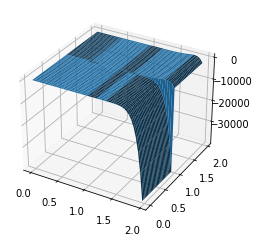

In [39]:
ax = plt.axes(projection='3d')
ax.plot_surface(X=xx, Y=yy, Z=plot2)

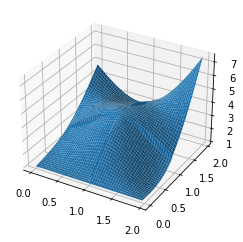

In [40]:
ax = plt.axes(projection='3d')
ax.plot_surface(X=xx, Y=yy, Z=plot)

In [41]:
import plotly.graph_objects as go

In [42]:
fig = go.Figure(data=[go.Surface(z=plot)])

fig.update_layout(title='Sistema solos',
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()

In [43]:
fig = go.Figure(data=[go.Surface(z=plot2)])

fig.update_layout(title='Sistema solos',
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()